In [1]:
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from PIL import Image
from collections import OrderedDict
from scipy.stats import pearsonr
import squidpy as sq
from sklearn.metrics import adjusted_rand_score, jaccard_score, mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

In [2]:
from utils import cluster, align_adata, column_corr, floatify, tocpu, alpha_shape
from utils import alpha_shape
# import STAGATE_pyG as STAGATE

In [3]:
from adjustText import adjust_text
import enlighten
import matplotlib.colors as colors

In [4]:
from pipelines.load import LoadCytAssistPipeline, LoadVisiumPipeline, LoadSeuratTonsilsPipeline
from pipelines.featurize import FeaturizePipeline
from pipelines.train import TrainModelPipeline
from pipelines.infer import InferencePipeline

In [5]:
antibody_panel = pd.read_csv('./antibody_panel.csv')

In [6]:
datasets = {}

In [7]:
tissue = 'Tonsil'

data_path = f'/ix/hosmanbeyoglu/spicess_datasets/{tissue}Tissue'

datasets['Tonsil 1'] = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    sample_id = 0,
    name = 'Tonsil 1',
).run()

datasets['Tonsil 2'] = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    sample_id = 1,
    name = 'Tonsil 2',
).run()

In [8]:
tissue = 'Breast'

data_path = f'/ix/hosmanbeyoglu/spicess_datasets/{tissue}Tissue'

datasets['Breast'] = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    sample_id = 0,
    name = f'{tissue} 1',
).run()

In [9]:
tissue = 'Brain'

data_path = f'/ix/hosmanbeyoglu/spicess_datasets/{tissue}Tissue'

datasets['Brain'] = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    sample_id = 0,
    name = f'{tissue} 1',
).run()

In [10]:
df = pd.read_csv('performance_heatmaps_v89.csv', index_col=0)

In [11]:
df1 = df[['Tonsil 2', 'Denoised Tonsil 2', 'cross-val 2', 'SPICESS', 'JAMIE', 'cTPnet 2']]
df1.columns = ['mRNA', 'Denoised mRNA', '* SPICESS Cross Val', '* SPICESS Val', 'JAMIE val', 'cTPnet val']
df2 = df[['Tonsil 1', 'Denoised Tonsil 1', 'cross-val', 'SPICESS 2', 'JAMIE 2', 'cTPnet']]
df2.columns = ['mRNA', 'Denoised mRNA', '* SPICESS Cross Val', '* SPICESS Val', 'JAMIE val', 'cTPnet val']
df1 = df1.drop(['Denoised mRNA', '* SPICESS Cross Val'], axis=1)
df1 = df1[['* SPICESS Val', 'JAMIE val', 'cTPnet val', 'mRNA']]
df1.columns = ['* SPICESS', 'JAMIE', 'cTPnet', 'mRNA']

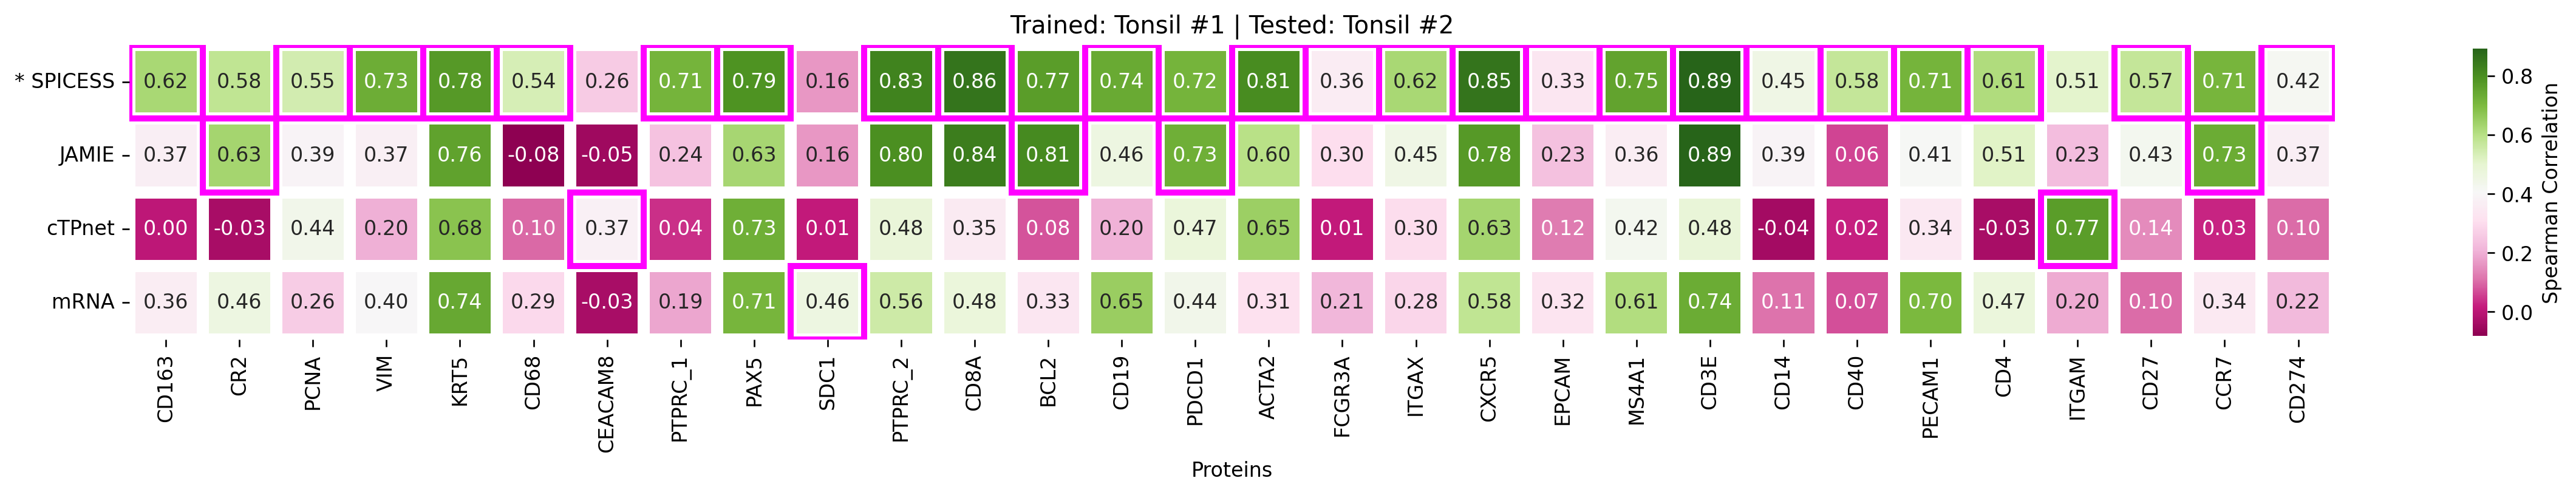

In [12]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.dpi'] = 120
data = pd.DataFrame(df1)
data_highlighted = data.copy()

data_highlighted.at['PECAM1', '* SPICESS'] = 0.71449

max_indices = pd.DataFrame(data_highlighted.values).idxmax(axis=1)
mask = pd.DataFrame(False, index=data_highlighted.index, columns=data_highlighted.columns)

for i, col in enumerate(max_indices):
    mask.iloc[i, col] = True
    
data_highlighted = data_highlighted.T

ax = sns.heatmap(
    data_highlighted, cmap='PiYG', linewidth=6, 
    linecolor='white', annot=True, fmt='.2f', 
    square=True, cbar=True, 
    cbar_kws={"orientation": "vertical", "shrink": 0.1, 
              "label": "Spearman Correlation"})

for i in range(len(data_highlighted)):
    for j in range(len(data_highlighted.columns)):
        if mask.T.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, 
            fill=False, edgecolor='magenta', lw=3))
        
plt.tight_layout()
plt.xlabel('Proteins')
plt.title('Trained: Tonsil #1 | Tested: Tonsil #2')
plt.show()

In [13]:
proteins = ['CD163', 'CR2', 'PCNA', 'VIM', 'KRT5', 'CD68', 'CEACAM8', 'PTPRC',
       'PAX5', 'SDC1', 'PTPRC', 'CD8A', 'BCL2', 'CD19', 'PDCD1', 'ACTA2',
       'FCGR3A', 'ITGAX', 'CXCR5', 'EPCAM', 'MS4A1', 'CD3E', 'CD14', 'CD40',
       'PECAM1', 'CD4', 'ITGAM', 'CD27', 'CCR7', 'CD274']

gene_f = FeaturizePipeline(clr=False, min_max=False, log=True)
protein_f = FeaturizePipeline(clr=True, min_max=False, log=False)

def compute_corr(name):
    adata_, pdata_ = datasets[name]
    adata = adata_.copy()
    pdata = pdata_.copy()
    
    sc.pp.filter_genes(adata, min_cells=5, inplace=True)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=5000)
    adata = adata[:, (adata.var['highly_variable'] | adata.var_names.isin(['PTPRC']+list(pdata.var_names)))]
    adata.X = adata.layers['counts']
    
    gene_f.run(adata)
    protein_f.run(pdata)
    
    mgex = adata.to_df(layer='normalized')[proteins]
    pex = pdata.to_df(layer='normalized').copy()

    adata_, pdata_ = datasets[name]
    adata = adata_.copy()
    pdata = pdata_.copy()

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150, verbose=False)
    
    # STAGATE.train_STAGATE(
    #     adata, lr=1e-4, n_epochs=1000, save_reconstrction=True, verbose=False)
    
    # agex = adata.to_df(layer='STAGATE_ReX')[proteins]

    agex = adata.to_df()[proteins]

    return np.array(column_corr(mgex.values, pex.values)), np.array(column_corr(agex.values, pex.values))    

In [ ]:
%%time

runs = {}
correlations = {}

runs['tonsil_1'] = pd.read_csv('tonsil_results.csv', index_col=0)
runs['tonsil_2'] = pd.read_csv('tonsil_results_2.csv', index_col=0)
runs['brain'] = pd.read_csv('brain_results.csv', index_col=0)
runs['breast'] = pd.read_csv('breast_results.csv', index_col=0)

for name in datasets.keys():    
    a, b = compute_corr(name)
    correlations[name] = a
    correlations['Denoised '+name] = b

# MoranI vs mRNA-Protein Correlation

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Breast']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = morans[i]
    b = correlations['Breast'][j]
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('MoranI')
plt.ylabel('mRNA-Protein Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    correlations['Breast']
).statistic

plt.title(f'Breast Cancer\nSpearmanr: {spr:.3f}')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Brain']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = morans[i]
    b = correlations['Brain'][j]
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('MoranI')
plt.ylabel('mRNA-Protein Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    correlations['Brain']
).statistic

plt.title(f'Brain Cancer\nSpearmanr: {spr:.3f}')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Tonsil 1']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = morans[i]
    b = correlations['Tonsil 1'][j]
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('MoranI')
plt.ylabel('mRNA-Protein Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    correlations['Tonsil 1']
).statistic

plt.title(f'Tonsil Cancer\nSpearmanr: {spr:.3f}')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Tonsil 2']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = morans[i]
    b = correlations['Tonsil 2'][j]
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('MoranI')
plt.ylabel('mRNA-Protein Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    correlations['Tonsil 2']
).statistic

plt.title(f'Tonsil 2 Cancer\nSpearmanr: {spr:.3f}')
plt.show()

# Measured Protein Expression vs Imputed Protein Performance

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Tonsil 1']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = pdata.to_df(layer='normalized')[i].mean()
    b = runs['tonsil_1'].T[i].mean()
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('Measured Protein Expression')
plt.ylabel('Imputed-vs-Measured Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    runs['tonsil_1'].mean(1)
).statistic

plt.title(f'Trained: Tonsil 1 | Tested: Tonsil 2\nSpearmanr: {spr:.3f}')
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Tonsil 2']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = pdata.to_df(layer='normalized')[i].mean()
    b = runs['tonsil_2'].T[i].mean()
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('Measured Protein Expression')
plt.ylabel('Imputed-vs-Measured Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    runs['tonsil_2'].mean(1)
).statistic

plt.title(f'Trained: Tonsil 2 | Tested: Tonsil 1\nSpearmanr: {spr:.3f}')
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Breast']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = pdata.to_df(layer='normalized')[i].mean()
    b = runs['breast'].T[i].mean()
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('Measured Protein Expression')
plt.ylabel('Imputed-vs-Measured Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    runs['breast'].mean(1)
).statistic

plt.title(f'Trained: Breast | Tested: 10x Cross Validation\nSpearmanr: {spr:.3f}')
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.rcParams['figure.dpi'] = 120

adata, pdata = datasets['Brain']
protein_f.run(pdata)

texts = []
morans = pdata.uns['moranI']['I'].to_dict()
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for j, i in enumerate(pdata.var_names):
    a = pdata.to_df(layer='normalized')[i].mean()
    b = runs['brain'].T[i].mean()
    ax.scatter(x=a, y=b)
    texts.append(
        ax.text(a, b, i, ha='center', va='center', fontsize=10)
    )

adjust_text(
    texts, 
    expand=(1.5, 2), 
    arrowprops=dict(arrowstyle='fancy', color='red')
)

plt.xlabel('Measured Protein Expression')
plt.ylabel('Imputed-vs-Measured Spearman Correlation')

spr = spearmanr(
    pdata.uns['moranI']['I'].loc[pdata.var_names].values, 
    runs['brain'].mean(1)
).statistic

plt.title(f'Trained: Brain | Tested: 10x Cross Validation\nSpearmanr: {spr:.3f}')
plt.tight_layout()
plt.show()